In [1]:
# Download Historical Stock Data

import pandas as pd
import yfinance as yf
import numpy as np

# Define the stock tickers and download data
tickers = ['AAPL', 'GOOGL', 'MSFT']
data = yf.download(tickers, start='2010-01-01', end='2024-01-06')

# Use the closing prices
data = data['Close']

# Check for NaN values in the dataset
nan_counts = data.isna().sum()
print("Number of NaN values in each column:\n", nan_counts)

# Display rows with NaN values
nan_rows = data[data.isna().any(axis=1)]
print("Rows with NaN values:\n", nan_rows)

# Fill missing values by backfilling
data = data.bfill()
print("Data after filling missing values:\n", data.head(25))


[*********************100%%**********************]  3 of 3 completed

Number of NaN values in each column:
 Ticker
AAPL     0
GOOGL    0
MSFT     0
dtype: int64
Rows with NaN values:
 Empty DataFrame
Columns: [AAPL, GOOGL, MSFT]
Index: []
Data after filling missing values:
 Ticker          AAPL      GOOGL       MSFT
Date                                      
2010-01-04  7.643214  15.684434  30.950001
2010-01-05  7.656429  15.615365  30.959999
2010-01-06  7.534643  15.221722  30.770000
2010-01-07  7.520714  14.867367  30.450001
2010-01-08  7.570714  15.065566  30.660000
2010-01-11  7.503929  15.042793  30.270000
2010-01-12  7.418571  14.776777  30.070000
2010-01-13  7.523214  14.691942  30.350000
2010-01-14  7.479643  14.761011  30.959999
2010-01-15  7.354643  14.514515  30.860001
2010-01-19  7.680000  14.705205  31.100000
2010-01-20  7.561786  14.524775  30.590000
2010-01-21  7.431071  14.589089  30.010000
2010-01-22  7.062500  13.764014  28.959999
2010-01-25  7.252500  13.513514  29.320000
2010-01-26  7.355000  13.574074  29.500000
2010-01-27  7.424286 

In [2]:
# Calculate the 50-day moving average for each stock
data['AAPL_MA50'] = data['AAPL'].rolling(window=50).mean()
data['GOOGL_MA50'] = data['GOOGL'].rolling(window=50).mean()
data['MSFT_MA50'] = data['MSFT'].rolling(window=50).mean()

# Fill NaN values created by rolling operation
data = data.bfill()

print("Data with 50-day moving average:\n", data.head(25))



Data with 50-day moving average:
 Ticker          AAPL      GOOGL       MSFT  AAPL_MA50  GOOGL_MA50  MSFT_MA50
Date                                                                        
2010-01-04  7.643214  15.684434  30.950001   7.391336   13.955175    29.1646
2010-01-05  7.656429  15.615365  30.959999   7.391336   13.955175    29.1646
2010-01-06  7.534643  15.221722  30.770000   7.391336   13.955175    29.1646
2010-01-07  7.520714  14.867367  30.450001   7.391336   13.955175    29.1646
2010-01-08  7.570714  15.065566  30.660000   7.391336   13.955175    29.1646
2010-01-11  7.503929  15.042793  30.270000   7.391336   13.955175    29.1646
2010-01-12  7.418571  14.776777  30.070000   7.391336   13.955175    29.1646
2010-01-13  7.523214  14.691942  30.350000   7.391336   13.955175    29.1646
2010-01-14  7.479643  14.761011  30.959999   7.391336   13.955175    29.1646
2010-01-15  7.354643  14.514515  30.860001   7.391336   13.955175    29.1646
2010-01-19  7.680000  14.705205  31.100000

In [3]:
# Scale the Data

from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler and fit to the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

print("Scaled data sample:\n", data_scaled[:5])


Scaled data sample:
 [[0.00410081 0.03434761 0.02207456 0.         0.01562903 0.0134612 ]
 [0.00416991 0.03385045 0.02210236 0.         0.01562903 0.0134612 ]
 [0.00353313 0.03101697 0.02157413 0.         0.01562903 0.0134612 ]
 [0.00346029 0.02846629 0.02068448 0.         0.01562903 0.0134612 ]
 [0.00372173 0.02989295 0.02126831 0.         0.01562903 0.0134612 ]]


In [4]:
# Function to split data into training and testing sets
def split_data(data, split_ratio=0.8):
    train_size = int(len(data) * split_ratio)
    train_data, test_data = data[:train_size], data[train_size:]
    print(f"Data split with ratio {split_ratio}: train size = {len(train_data)}, test size = {len(test_data)}")
    return train_data, test_data

split_ratios = [0.8]
datasets = [split_data(data_scaled, ratio) for ratio in split_ratios]

for i, (train_data, test_data) in enumerate(datasets):
    print(f"Training data size for split {split_ratios[i]*100}-{(1-split_ratios[i])*100}: {train_data.shape}")
    print(f"Testing data size for split {split_ratios[i]*100}-{(1-split_ratios[i])*100}: {test_data.shape}")


Data split with ratio 0.8: train size = 2820, test size = 706
Training data size for split 80.0-19.999999999999996: (2820, 6)
Testing data size for split 80.0-19.999999999999996: (706, 6)


In [5]:
# Create Time-Series Data for LSTM
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]  # Create feature set
        X.append(a)
        Y.append(dataset[i + time_step, 0])  # Create label set
    return np.array(X), np.array(Y)

time_step = 100
datasets_ts = [(create_dataset(train, time_step), create_dataset(test, time_step)) for train, test in datasets]

for i, ((X_train, y_train), (X_test, y_test)) in enumerate(datasets_ts):
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    print(f"X_train shape for split {split_ratios[i]*100}-{(1-split_ratios[i])*100}: {X_train.shape}")
    print(f"X_test shape for split {split_ratios[i]*100}-{(1-split_ratios[i])*100}: {X_test.shape}")


X_train shape for split 80.0-19.999999999999996: (2719, 100, 1)
X_test shape for split 80.0-19.999999999999996: (605, 100, 1)


In [6]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [7]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [8]:
# Build and Train LSTM Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Build and Train LSTM Model
def build_and_train_lstm(X_train, y_train, X_test, y_test, epochs=10, batch_size=1):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
    return model, history

hyperparams = [
    {'epochs': 2, 'batch_size': 1},
    {'epochs': 2, 'batch_size': 32}
#   {'epochs': 5, 'batch_size': 1},
#   {'epochs': 5, 'batch_size': 32}
]

lstm_results = []
for i, ((X_train, y_train), (X_test, y_test)) in enumerate(datasets_ts):
    for params in hyperparams:
        print(f"Training LSTM model with split {split_ratios[i]*100}-{(1-split_ratios[i])*100} and params {params}...")
        model, history = build_and_train_lstm(X_train, y_train, X_test, y_test, epochs=params['epochs'], batch_size=params['batch_size'])
        lstm_results.append((model, history, f"Split {split_ratios[i]*100}-{(1-split_ratios[i])*100}, Params {params}"))


Training LSTM model with split 80.0-19.999999999999996 and params {'epochs': 2, 'batch_size': 1}...
Epoch 1/2
2719/2719 [==============================] - 34s 11ms/step - loss: 4.4065e-04 - val_loss: 5.4645e-04
Epoch 2/2
2719/2719 [==============================] - 27s 10ms/step - loss: 2.7276e-04 - val_loss: 0.0011
Training LSTM model with split 80.0-19.999999999999996 and params {'epochs': 2, 'batch_size': 32}...
Epoch 1/2
85/85 [==============================] - 5s 25ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 2/2
85/85 [==============================] - 2s 23ms/step - loss: 1.4433e-04 - val_loss: 0.0011


In [9]:
# Build and Train GRU Model

from tensorflow.keras.layers import GRU

def build_and_train_gru(X_train, y_train, X_test, y_test, epochs=10, batch_size=1):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(GRU(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
    return model, history

gru_results = []
for i, ((X_train, y_train), (X_test, y_test)) in enumerate(datasets_ts):
    for params in hyperparams:
        print(f"Training GRU model with split {split_ratios[i]*100}-{(1-split_ratios[i])*100} and params {params}...")
        model, history = build_and_train_gru(X_train, y_train, X_test, y_test, epochs=params['epochs'], batch_size=params['batch_size'])
        gru_results.append((model, history, f"Split {split_ratios[i]*100}-{(1-split_ratios[i])*100}, Params {params}"))


Training GRU model with split 80.0-19.999999999999996 and params {'epochs': 2, 'batch_size': 1}...
Epoch 1/2
2719/2719 [==============================] - 30s 10ms/step - loss: 3.3493e-04 - val_loss: 5.0117e-04
Epoch 2/2
2719/2719 [==============================] - 26s 10ms/step - loss: 1.8682e-04 - val_loss: 0.0011
Training GRU model with split 80.0-19.999999999999996 and params {'epochs': 2, 'batch_size': 32}...
Epoch 1/2
85/85 [==============================] - 5s 18ms/step - loss: 0.0025 - val_loss: 4.9722e-04
Epoch 2/2
85/85 [==============================] - 1s 10ms/step - loss: 6.2016e-05 - val_loss: 4.6180e-04


In [10]:
# Evaluate Models

from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(model, X_train, y_train, X_test, y_test, scaler):
    # Make predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Invert predictions to original scale
    train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], scaler.scale_.shape[0] - 1))), axis=1))[:,0]
    test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], scaler.scale_.shape[0] - 1))), axis=1))[:,0]
    y_train = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], scaler.scale_.shape[0] - 1))), axis=1))[:,0]
    y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaler.scale_.shape[0] - 1))), axis=1))[:,0]

    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y_test, test_predict))
    mae = mean_absolute_error(y_test, test_predict)
    r2 = np.corrcoef(y_test, test_predict)[0, 1]**2

    return rmse, mae, r2, y_test, test_predict

# Evaluate LSTM models
lstm_eval_results = []
for model, history, desc in lstm_results:
    for i, ((X_train, y_train), (X_test, y_test)) in enumerate(datasets_ts):
        rmse, mae, r2, y_test_lstm, test_predict_lstm = evaluate_model(model, X_train, y_train, X_test, y_test, scaler)
        lstm_eval_results.append((rmse, mae, r2, desc))

# Evaluate GRU models
gru_eval_results = []
for model, history, desc in gru_results:
    for i, ((X_train, y_train), (X_test, y_test)) in enumerate(datasets_ts):
        rmse, mae, r2, y_test_gru, test_predict_gru = evaluate_model(model, X_train, y_train, X_test, y_test, scaler)
        gru_eval_results.append((rmse, mae, r2, desc))

# Print evaluation results
print("\nLSTM Evaluation Results:")
for rmse, mae, r2, desc in lstm_eval_results:
    print(f"{desc} - RMSE: {rmse}, MAE: {mae}, R-squared: {r2}")

print("\nGRU Evaluation Results:")
for rmse, mae, r2, desc in gru_eval_results:
    print(f"{desc} - RMSE: {rmse}, MAE: {mae}, R-squared: {r2}")


19/19 [==============================] - 0s 6ms/step

LSTM Evaluation Results:
Split 80.0-19.999999999999996, Params {'epochs': 2, 'batch_size': 1} - RMSE: 6.398614306102205, MAE: 5.564658051712442, R-squared: 0.959181079910067
Split 80.0-19.999999999999996, Params {'epochs': 2, 'batch_size': 32} - RMSE: 6.219763902655269, MAE: 5.230049496164044, R-squared: 0.8721676431735332

GRU Evaluation Results:
Split 80.0-19.999999999999996, Params {'epochs': 2, 'batch_size': 1} - RMSE: 6.316188112264556, MAE: 5.699019648233344, R-squared: 0.972663137935644
Split 80.0-19.999999999999996, Params {'epochs': 2, 'batch_size': 32} - RMSE: 4.109892988758161, MAE: 3.256872626304513, R-squared: 0.9430105279302932


In [15]:
# Install Google Chrome
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i google-chrome-stable_current_amd64.deb
!apt-get -f install -y

--2024-07-24 00:23:48--  https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
Resolving dl.google.com (dl.google.com)... 142.251.107.136, 142.251.107.190, 142.251.107.93, ...
Connecting to dl.google.com (dl.google.com)|142.251.107.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109166380 (104M) [application/x-debian-package]
Saving to: ‘google-chrome-stable_current_amd64.deb’

google-chrome-stabl 100%[===================>] 104.11M   370MB/s    in 0.3s    

2024-07-24 00:23:48 (370 MB/s) - ‘google-chrome-stable_current_amd64.deb’ saved [109166380/109166380]

Selecting previously unselected package google-chrome-stable.
(Reading database ... 123589 files and directories currently installed.)
Preparing to unpack google-chrome-stable_current_amd64.deb ...
Unpacking google-chrome-stable (127.0.6533.72-1) ...
dpkg: dependency problems prevent configuration of google-chrome-stable:
 google-chrome-stable depends on libu2f-udev; however:
  Pack

In [16]:
!google-chrome --version

Google Chrome 127.0.6533.72 


In [20]:
# You will need to install chrome driver for this section to work correctly

# Ensure the uploaded file is listed
!ls

# Unzip the uploaded ChromeDriver file with overwrite option
!unzip -o chromedriver_linux64.zip

# Move the chromedriver to /usr/bin/ and set permissions
!chmod +x chromedriver-linux64/chromedriver
!mv chromedriver-linux64/chromedriver /usr/bin/chromedriver

# Set up environment variables
import os
os.environ['PATH'] += ':/usr/bin/'

# Print the PATH variable to ensure chromedriver is in the PATH
print(os.environ['PATH'])


# Install the necessary packages
!apt-get update
!apt-get install -y wget unzip
!pip install selenium
!pip install vaderSentiment


# Collect News Data
import os
import pandas as pd
import numpy as np
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
#from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import matplotlib.pyplot as plt


# Set up Chrome options
chrome_options = Options()
chrome_options.add_argument("--headless")  # Run Chrome in headless mode
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Define the path to chromedriver
chromedriver_path = '/usr/bin/chromedriver'

def scrape_news(stock):
    driver = webdriver.Chrome(service=Service(chromedriver_path), options=chrome_options)
    url = f'https://news.google.com/search?q={stock}%20stock&hl=en-US&gl=US&ceid=US%3Aen'
    driver.get(url)

    # Allow time for the page to load and find headlines
    try:
        print(f"Fetching news for {stock}...")
        article_elements = WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'article.IFHyqb'))
        )

        headlines = []
        for article in article_elements:
            headline_element = article.find_element(By.CSS_SELECTOR, 'a.JtKRv')
            if headline_element:
                headlines.append(headline_element.text)

        print(f"Headlines found: {headlines}")
    except Exception as e:
        print(f"An error occurred: {e}")
        headlines = []
    finally:
        driver.quit()

    return headlines

# Scrape news for each stock
news_aapl = scrape_news('AAPL')
news_googl = scrape_news('GOOGL')
news_msft = scrape_news('MSFT')




chromedriver-linux64  chromedriver_linux64.zip	google-chrome-stable_current_amd64.deb	sample_data
Archive:  chromedriver_linux64.zip
  inflating: chromedriver-linux64/LICENSE.chromedriver  
  inflating: chromedriver-linux64/THIRD_PARTY_NOTICES.chromedriver  
  inflating: chromedriver-linux64/chromedriver  
/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/usr/bin/:/usr/bin/:/usr/bin/:/usr/bin/:/usr/bin/:/usr/bin/:/usr/bin/
Hit:1 https://dl.google.com/linux/chrome/deb stable InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy Release
H

In [21]:
# Sentiment Analysis

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define function to calculate sentiment scores
def get_sentiment_scores(headlines):
    scores = [analyzer.polarity_scores(headline)['compound'] for headline in headlines]
    return scores

# Get sentiment scores for each stock
sentiment_aapl = get_sentiment_scores(news_aapl)
sentiment_googl = get_sentiment_scores(news_googl)
sentiment_msft = get_sentiment_scores(news_msft)

# Ensure the lengths of sentiment arrays are the same
min_length = min(len(sentiment_aapl), len(sentiment_googl), len(sentiment_msft))
sentiment_aapl = sentiment_aapl[:min_length]
sentiment_googl = sentiment_googl[:min_length]
sentiment_msft = sentiment_msft[:min_length]

# Calculate average sentiment
avg_sentiment_aapl = sum(sentiment_aapl) / len(sentiment_aapl)
avg_sentiment_googl = sum(sentiment_googl) / len(sentiment_googl)
avg_sentiment_msft = sum(sentiment_msft) / len(sentiment_msft)

print(f'Average Sentiment - AAPL: {avg_sentiment_aapl}, GOOGL: {avg_sentiment_googl}, MSFT: {avg_sentiment_msft}')

Average Sentiment - AAPL: 0.183831, GOOGL: 0.22921399999999997, MSFT: 0.142723


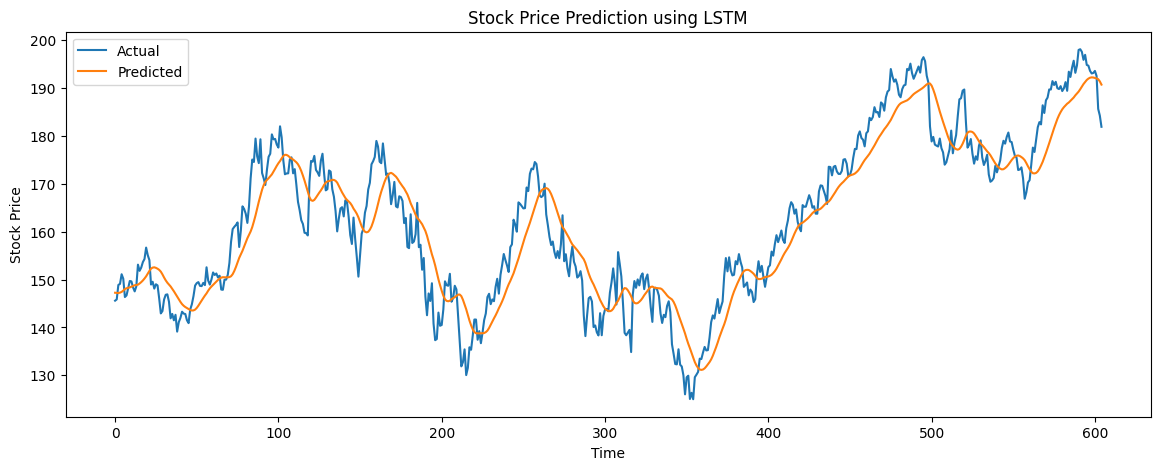

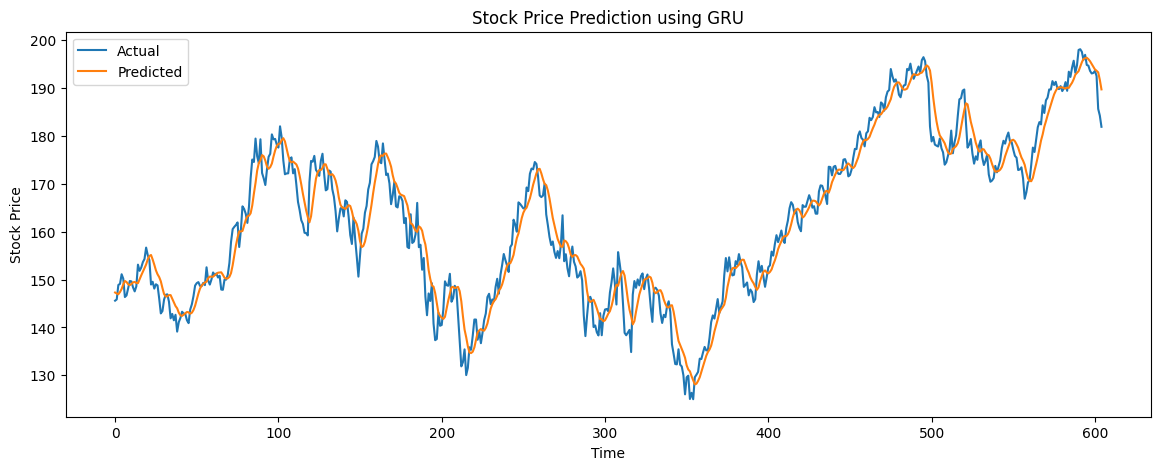

In [22]:
# Visualizations

import matplotlib.pyplot as plt

# Plot LSTM predictions vs actual values
plt.figure(figsize=(14, 5))
plt.plot(y_test_lstm, label='Actual')
plt.plot(test_predict_lstm, label='Predicted')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Plot GRU predictions vs actual values
plt.figure(figsize=(14, 5))
plt.plot(y_test_gru, label='Actual')
plt.plot(test_predict_gru, label='Predicted')
plt.title('Stock Price Prediction using GRU')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()



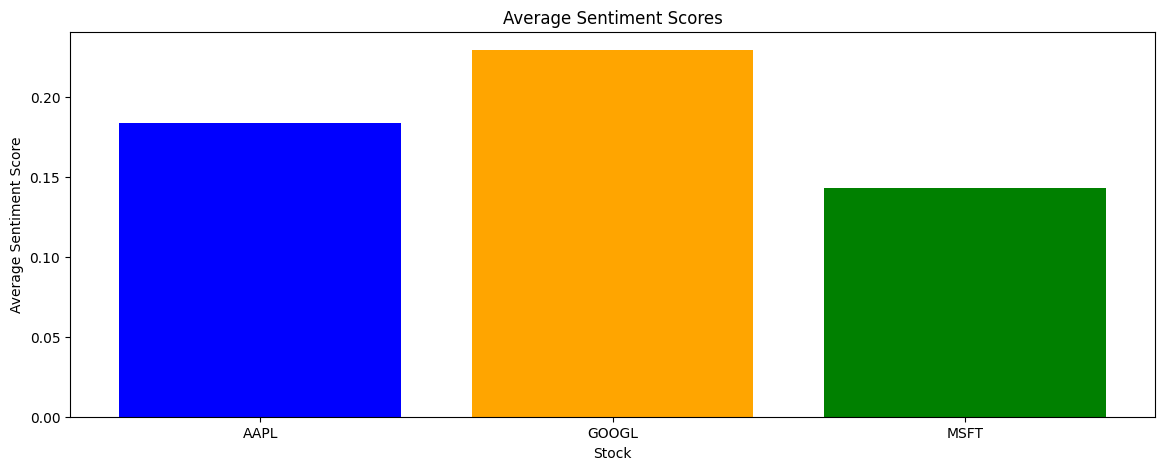

In [23]:
# Plot sentiment scores for each stock
plt.figure(figsize=(14, 5))
plt.bar(['AAPL', 'GOOGL', 'MSFT'], [avg_sentiment_aapl, avg_sentiment_googl, avg_sentiment_msft], color=['blue', 'orange', 'green'])
plt.title('Average Sentiment Scores')
plt.xlabel('Stock')
plt.ylabel('Average Sentiment Score')
plt.show()



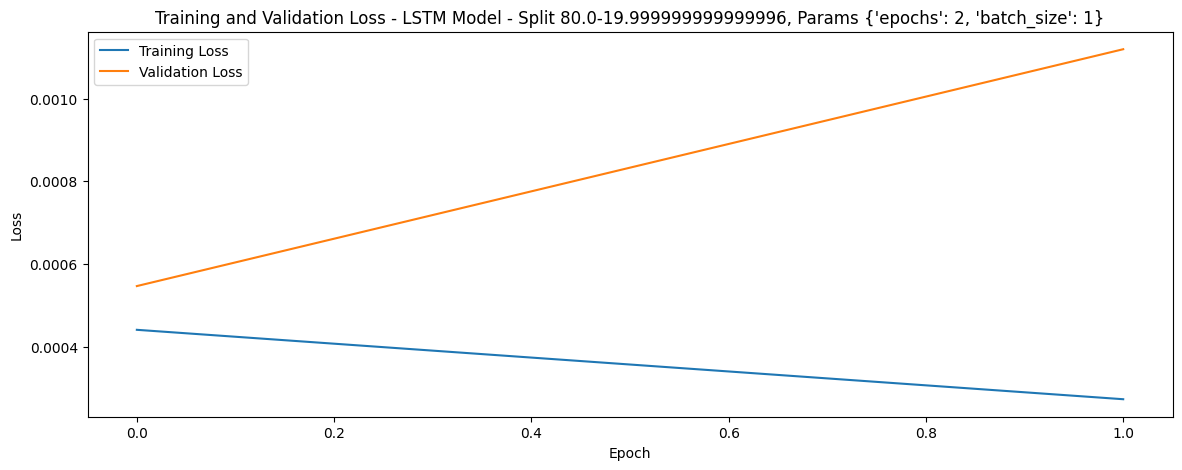

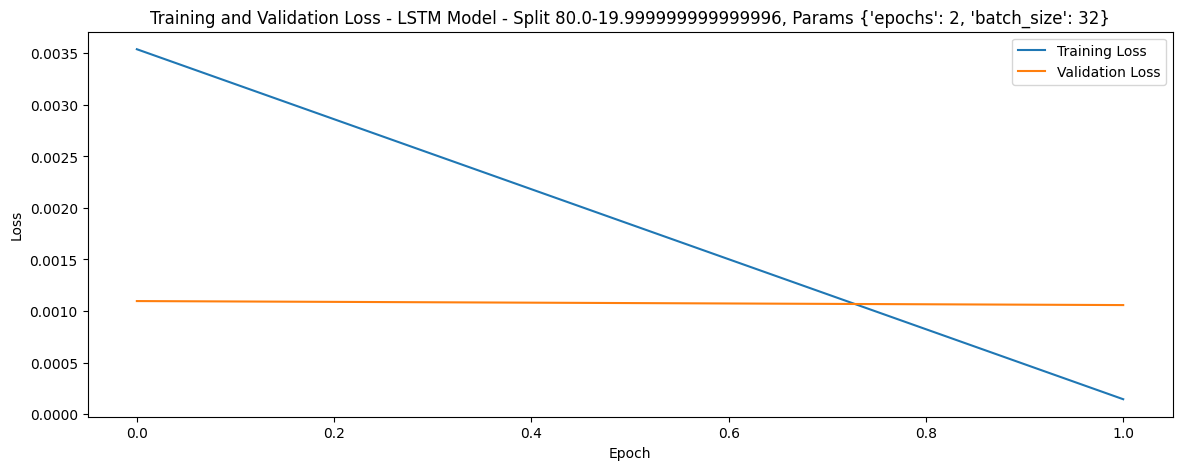

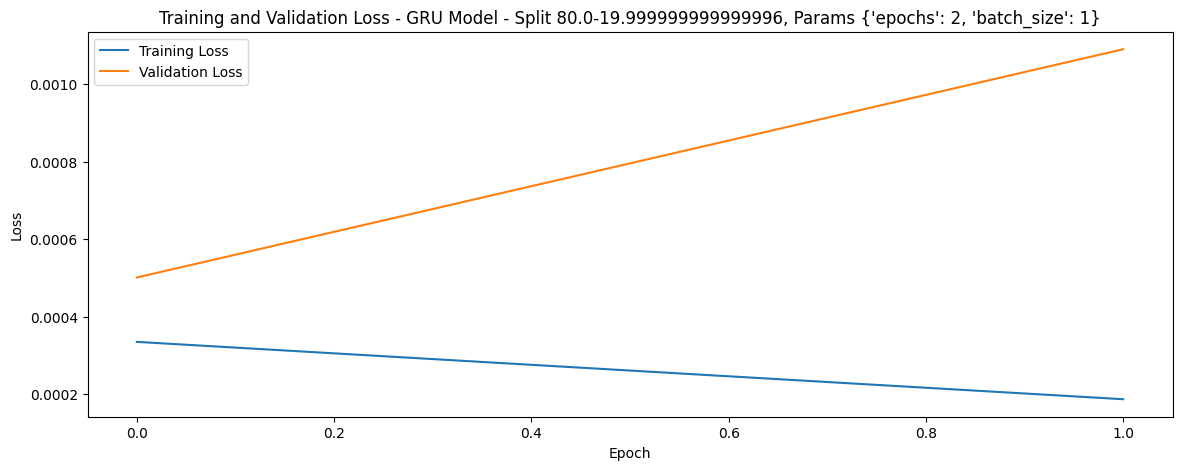

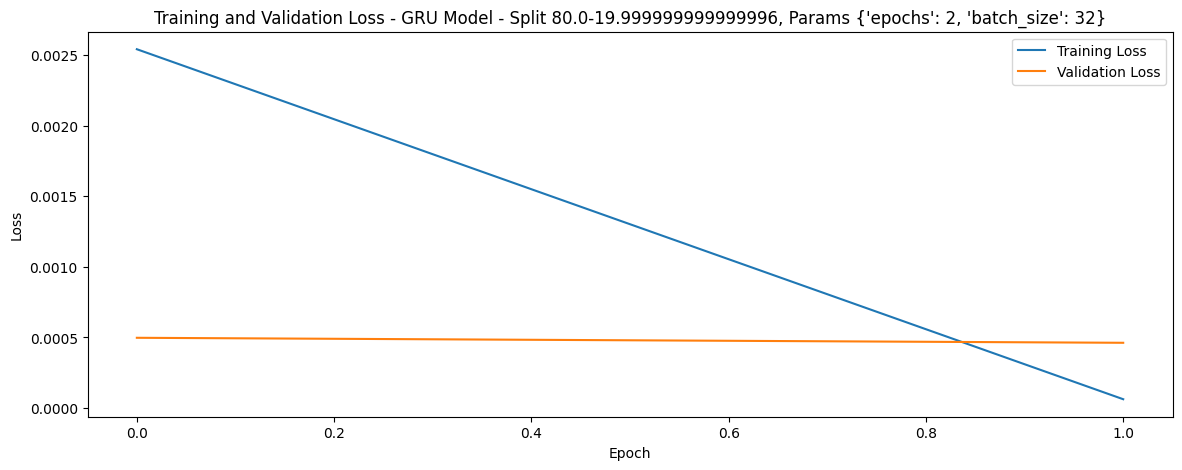

In [24]:
# Plot training and validation loss for LSTM model
for model, history, desc in lstm_results:
    plt.figure(figsize=(14, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss - LSTM Model - {desc}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot training and validation loss for GRU model
for model, history, desc in gru_results:
    plt.figure(figsize=(14, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss - GRU Model - {desc}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [25]:
# Integrate Sentiment Data with Stock Prices

# Sample stock price data
dates = pd.date_range(start='2024-01-01', periods=min_length, freq='D')
data = pd.DataFrame(index=dates)
data['AAPL'] = np.random.rand(min_length)  # Replace with actual stock price data
data['GOOGL'] = np.random.rand(min_length)  # Replace with actual stock price data
data['MSFT'] = np.random.rand(min_length)  # Replace with actual stock price data

# Convert sentiment scores to DataFrame
sentiment_df = pd.DataFrame({
    'AAPL_Sentiment': sentiment_aapl,
    'GOOGL_Sentiment': sentiment_googl,
    'MSFT_Sentiment': sentiment_msft
}, index=dates)  # Ensure indices match

# Combine sentiment scores with stock price data
data = data.join(sentiment_df, how='inner')

# Fill missing values created by aligning the sentiment data with the stock price data
data = data.bfill()

# Scale the updated data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Function to create dataset for LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Function to split data into training and testing sets
def split_data(dataset, ratio=0.8):
    train_size = int(len(dataset) * ratio)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
    return train, test

# Prepare data for LSTM with sentiment
time_step = 10
split_ratios = [0.8]
datasets = [split_data(data_scaled, ratio) for ratio in split_ratios]
datasets_ts = [(create_dataset(train, time_step), create_dataset(test, time_step)) for train, test in datasets]

for i, ((X_train, y_train), (X_test, y_test)) in enumerate(datasets_ts):
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
    print(f"X_train shape for split {split_ratios[i]*100}-{(1-split_ratios[i])*100} with sentiment: {X_train.shape}")
    print(f"X_test shape for split {split_ratios[i]*100}-{(1-split_ratios[i])*100} with sentiment: {X_test.shape}")

# Define the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Define the GRU model
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=input_shape))
    model.add(GRU(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Function to train and evaluate the model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=2, batch_size=1):
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=2)
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, test_predict))
    mae = mean_absolute_error(y_test, test_predict)
    r2 = r2_score(y_test, test_predict)
    return rmse, mae, r2

# Train and evaluate models
rmse_lstm, mae_lstm, r2_lstm = train_and_evaluate_model(build_lstm_model((time_step, data_scaled.shape[1])),
                                                        X_train, y_train, X_test, y_test, epochs=2, batch_size=1)
rmse_gru, mae_gru, r2_gru = train_and_evaluate_model(build_gru_model((time_step, data_scaled.shape[1])),
                                                     X_train, y_train, X_test, y_test, epochs=2, batch_size=1)



X_train shape for split 80.0-19.999999999999996 with sentiment: (69, 10, 6)
X_test shape for split 80.0-19.999999999999996 with sentiment: (9, 10, 6)
Epoch 1/2
69/69 - 5s - loss: 0.1107 - val_loss: 0.1058 - 5s/epoch - 66ms/step
Epoch 2/2
69/69 - 0s - loss: 0.1018 - val_loss: 0.1656 - 321ms/epoch - 5ms/step
1/1 [==============================] - 0s 18ms/step
Epoch 1/2
69/69 - 4s - loss: 0.1097 - val_loss: 0.0836 - 4s/epoch - 55ms/step
Epoch 2/2
69/69 - 0s - loss: 0.0953 - val_loss: 0.1997 - 326ms/epoch - 5ms/step
1/1 [==============================] - 0s 17ms/step


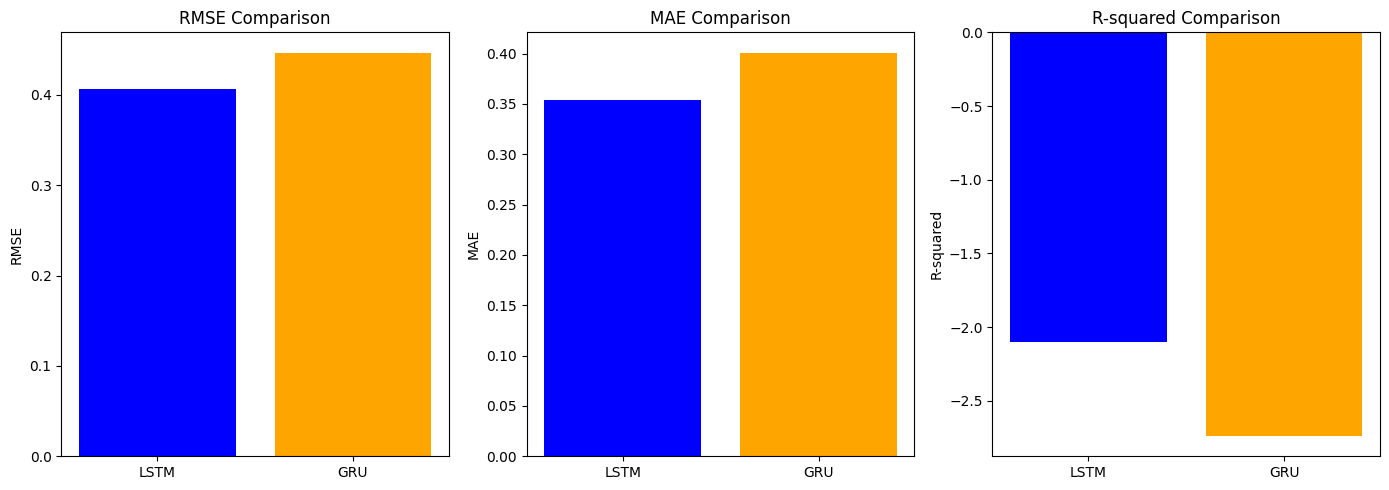

In [26]:
# Comparison of model performance with sentiment integration
models = ['LSTM', 'GRU']
rmse_scores = [rmse_lstm, rmse_gru]
mae_scores = [mae_lstm, mae_gru]
r2_scores = [r2_lstm, r2_gru]

x = np.arange(len(models))

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.bar(x, rmse_scores, color=['blue', 'orange'])
plt.xticks(x, models)
plt.title('RMSE Comparison')
plt.ylabel('RMSE')

plt.subplot(1, 3, 2)
plt.bar(x, mae_scores, color=['blue', 'orange'])
plt.xticks(x, models)
plt.title('MAE Comparison')
plt.ylabel('MAE')

plt.subplot(1, 3, 3)
plt.bar(x, r2_scores, color=['blue', 'orange'])
plt.xticks(x, models)
plt.title('R-squared Comparison')
plt.ylabel('R-squared')

plt.tight_layout()
plt.show()


In [27]:
# Function to process data for a specific stock
def process_stock_data(stock_data):
    stock_data = stock_data.rolling(window=50).mean()
    stock_data = stock_data.bfill()
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(stock_data.values.reshape(-1, 1))
    return stock_data, data_scaled, scaler

# Function to create dataset for LSTM
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

# Function to split data into training and testing sets
def split_data(data, split_ratio=0.8):
    train_size = int(len(data) * split_ratio)
    train_data, test_data = data[:train_size], data[train_size:]
    return train_data, test_data

# Function to build and train LSTM model
def build_and_train_lstm(X_train, y_train, X_test, y_test, epochs=2, batch_size=1, time_step=10):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
    return model, history

# Function to build and train GRU model
def build_and_train_gru(X_train, y_train, X_test, y_test, epochs=2, batch_size=1, time_step=10):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(GRU(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
    return model, history

# Function to evaluate model
def evaluate_model(model, X_test, y_test, scaler):
    test_predict = model.predict(X_test)
    test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], 1))), axis=1))[:, 0]
    y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:, 0]
    rmse = np.sqrt(mean_squared_error(y_test, test_predict))
    mae = mean_absolute_error(y_test, test_predict)
    r2 = np.corrcoef(y_test, test_predict)[0, 1] ** 2
    return rmse, mae, r2, y_test, test_predict

# Function to plot projected stock prices
def plot_projected_prices(dates, y_test, test_predict, title):
    print(f"Plotting: {title}")
    print(f"Dates: {dates}")
    print(f"y_test: {y_test}")
    print(f"test_predict: {test_predict}")
    plt.figure(figsize=(14, 5))
    plt.plot(dates, y_test, label='Actual Stock Price', color='blue')
    plt.plot(dates, test_predict, label='Predicted Stock Price', color='orange')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



Data length for AAPL after scaling: 100
Epoch 1/2
69/69 [==============================] - 4s 15ms/step - loss: 0.0630 - val_loss: 0.0781
Epoch 2/2
1/1 [==============================] - 1s 848ms/step
Plotting: Projected Stock Prices using LSTM for AAPL with split ratio 0.8
Dates: DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09'],
              dtype='datetime64[ns]', freq='D')
y_test: [0.49201923 0.49377136 0.48130493 0.48567444 0.48004944 0.47295223
 0.45874143 0.4435765  0.43638436]
test_predict: [0.48622189 0.48850029 0.49033883 0.49134118 0.49203081 0.49192204
 0.49116398 0.48823112 0.48430424]


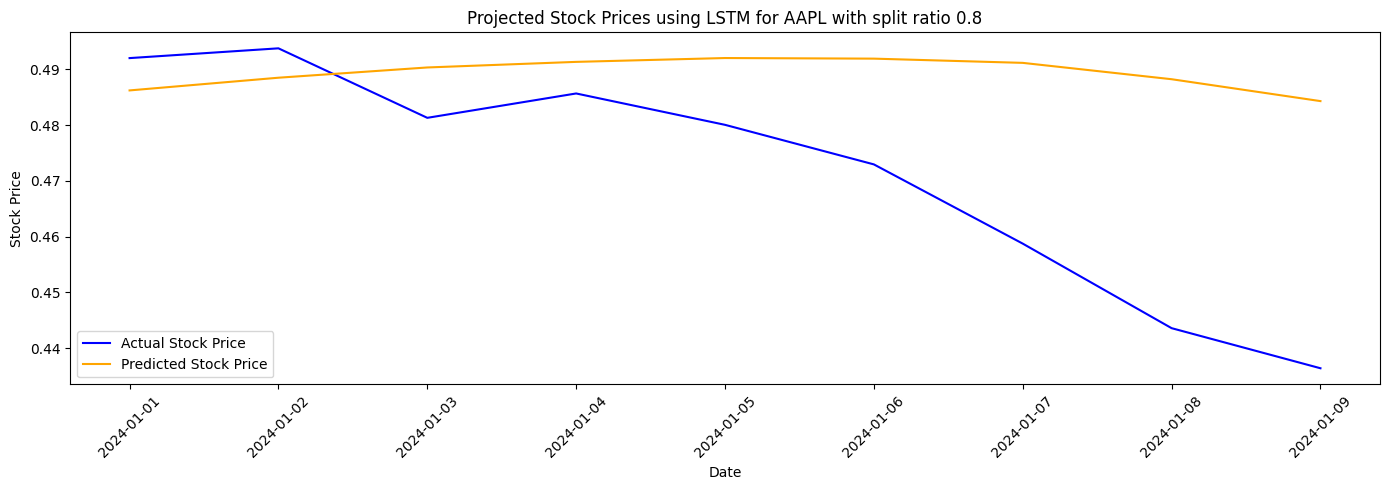

Epoch 1/2
3/3 [==============================] - 8s 527ms/step - loss: 0.6655 - val_loss: 0.0576
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.3183 - val_loss: 0.0296


1/1 [==============================] - 1s 597ms/step
Plotting: Projected Stock Prices using LSTM for AAPL with split ratio 0.8
Dates: DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09'],
              dtype='datetime64[ns]', freq='D')
y_test: [0.49201923 0.49377136 0.48130493 0.48567444 0.48004944 0.47295223
 0.45874143 0.4435765  0.43638436]
test_predict: [0.47059918 0.47167785 0.47254207 0.47302056 0.47336653 0.47333939
 0.4730163  0.47163572 0.46978639]


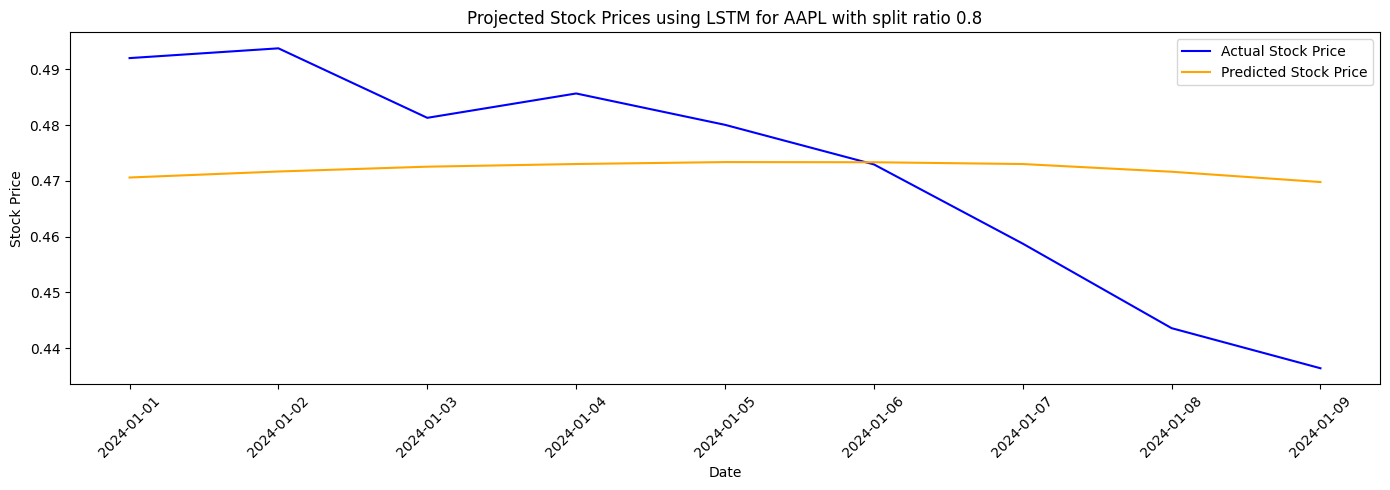

Epoch 1/2
69/69 [==============================] - 5s 14ms/step - loss: 0.0644 - val_loss: 0.0353
Epoch 2/2
69/69 [==============================] - 0s 5ms/step - loss: 0.0061 - val_loss: 0.0329


1/1 [==============================] - 1s 518ms/step
Plotting: Projected Stock Prices using GRU for AAPL with split ratio 0.8
Dates: DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09'],
              dtype='datetime64[ns]', freq='D')
y_test: [0.49201923 0.49377136 0.48130493 0.48567444 0.48004944 0.47295223
 0.45874143 0.4435765  0.43638436]
test_predict: [0.49443467 0.49615336 0.49674766 0.49392547 0.49184546 0.48913883
 0.48522488 0.47850461 0.46906352]


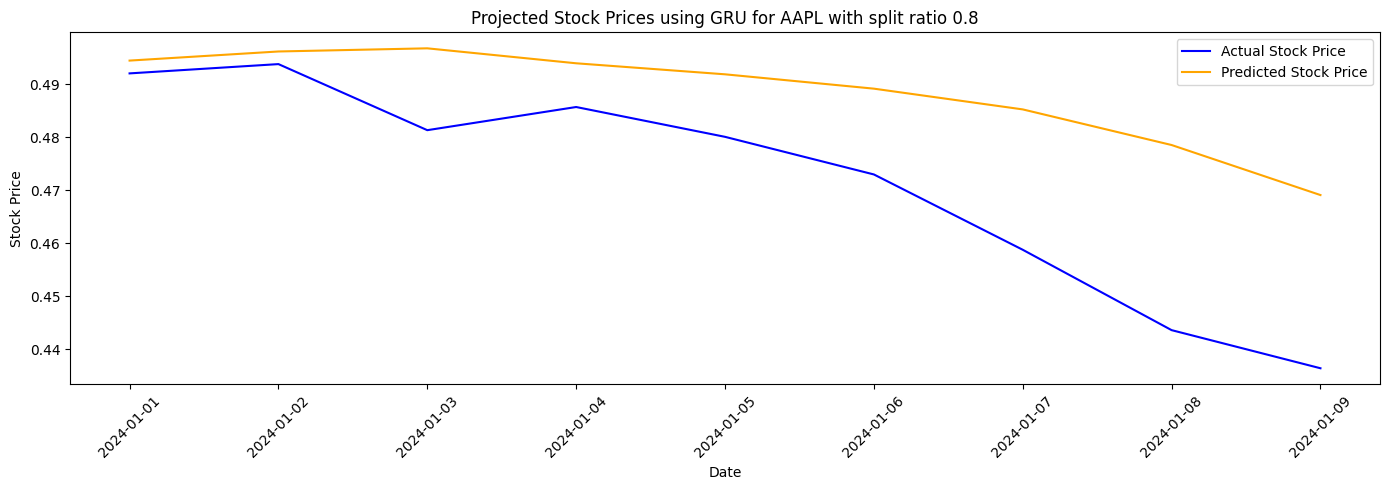

Epoch 1/2
3/3 [==============================] - 4s 318ms/step - loss: 0.3154 - val_loss: 0.0204
Epoch 2/2
1/1 [==============================] - 1s 553ms/step
Plotting: Projected Stock Prices using GRU for AAPL with split ratio 0.8
Dates: DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09'],
              dtype='datetime64[ns]', freq='D')
y_test: [0.49201923 0.49377136 0.48130493 0.48567444 0.48004944 0.47295223
 0.45874143 0.4435765  0.43638436]
test_predict: [0.5031959  0.50488637 0.50580305 0.50444279 0.50323569 0.5014039
 0.4986513  0.49385543 0.48706833]


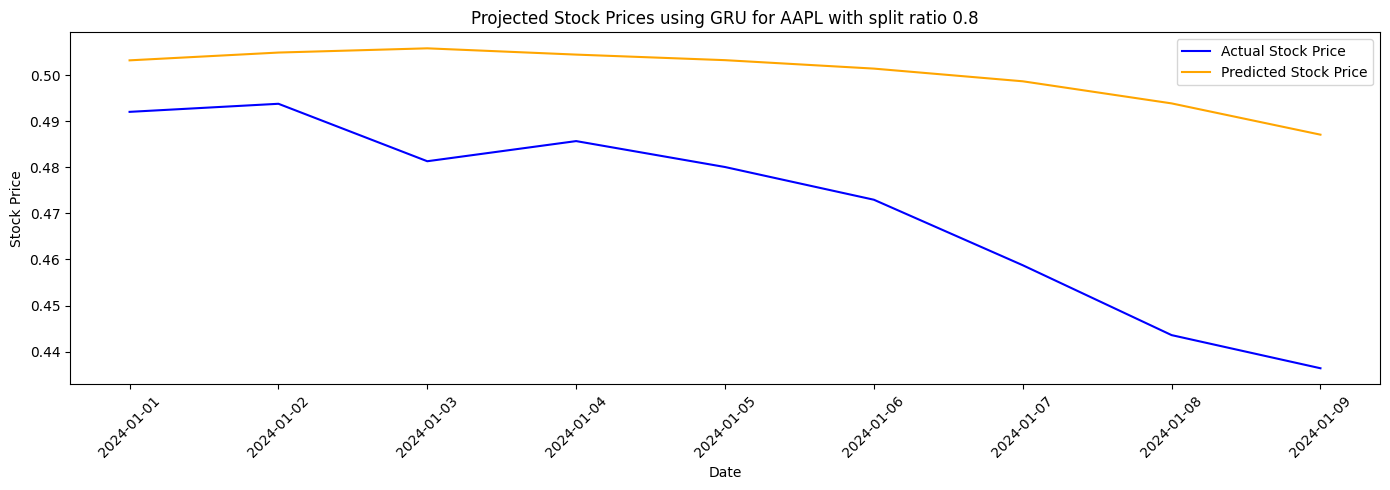

Data length for GOOGL after scaling: 100
Epoch 1/2
69/69 [==============================] - 5s 15ms/step - loss: 0.0634 - val_loss: 0.0659
Epoch 2/2
1/1 [==============================] - 1s 567ms/step
Plotting: Projected Stock Prices using LSTM for GOOGL with split ratio 0.8
Dates: DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09'],
              dtype='datetime64[ns]', freq='D')
y_test: [0.46357678 0.47132386 0.46711145 0.45292599 0.4414459  0.44797906
 0.42987126 0.42277203 0.41755945]
test_predict: [0.51591104 0.51345903 0.5114612  0.51004333 0.50720573 0.50382081
 0.4998437  0.49521953 0.49005056]


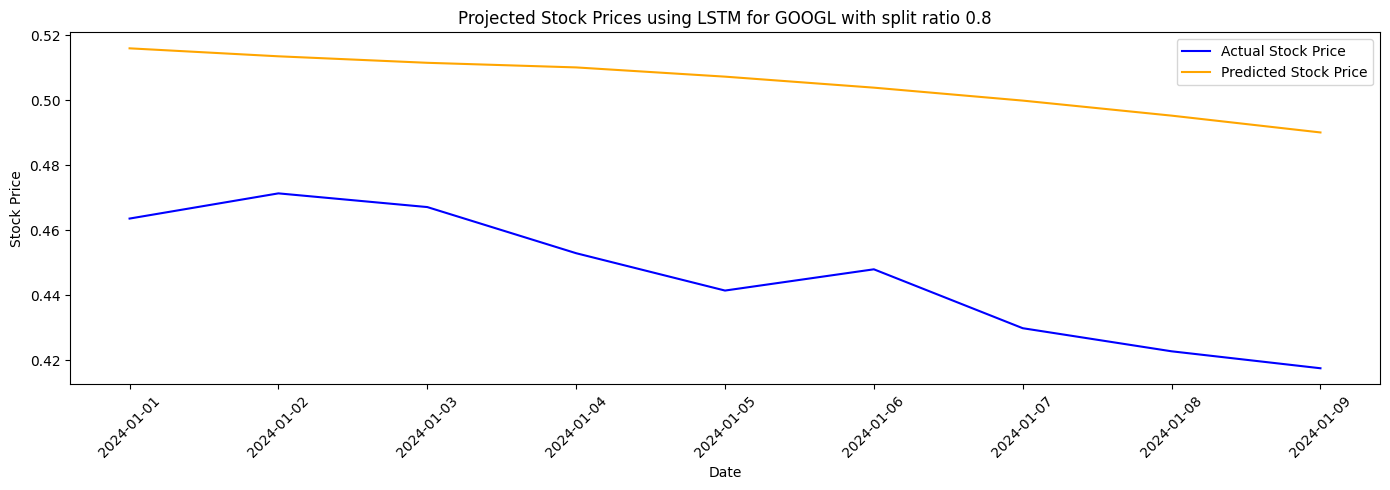

Epoch 1/2
3/3 [==============================] - 4s 650ms/step - loss: 0.5998 - val_loss: 0.0076
Epoch 2/2
1/1 [==============================] - 1s 605ms/step
Plotting: Projected Stock Prices using LSTM for GOOGL with split ratio 0.8
Dates: DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09'],
              dtype='datetime64[ns]', freq='D')
y_test: [0.46357678 0.47132386 0.46711145 0.45292599 0.4414459  0.44797906
 0.42987126 0.42277203 0.41755945]
test_predict: [0.48111683 0.47942363 0.47810973 0.47737118 0.4754667  0.47328682
 0.47042652 0.46711651 0.46339001]


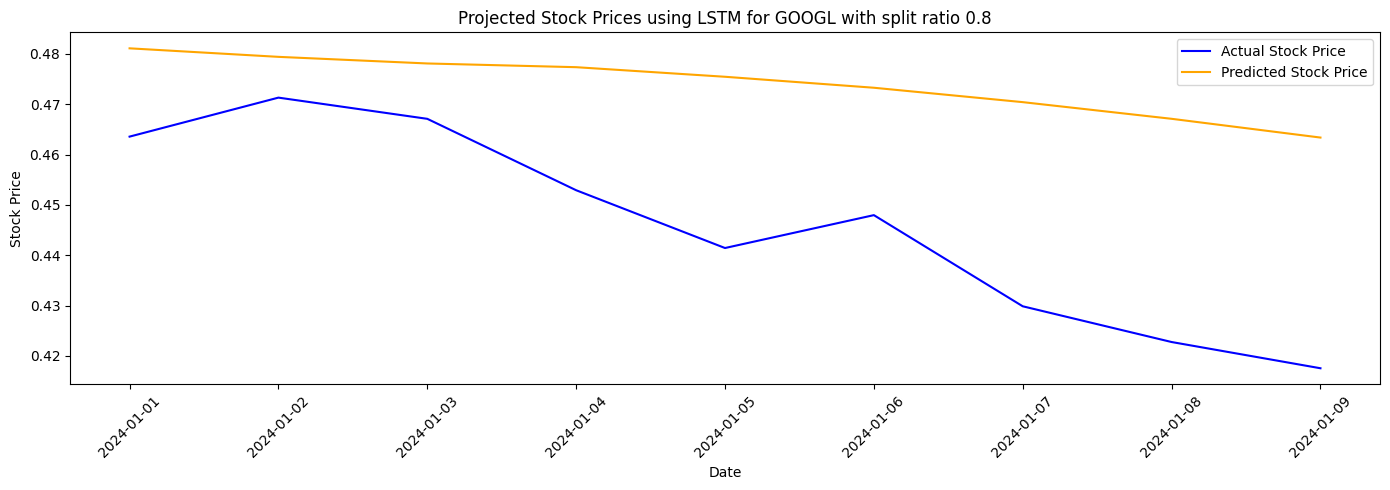

Epoch 1/2
69/69 [==============================] - 4s 14ms/step - loss: 0.0368 - val_loss: 0.0720
Epoch 2/2
1/1 [==============================] - 1s 552ms/step
Plotting: Projected Stock Prices using GRU for GOOGL with split ratio 0.8
Dates: DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09'],
              dtype='datetime64[ns]', freq='D')
y_test: [0.46357678 0.47132386 0.46711145 0.45292599 0.4414459  0.44797906
 0.42987126 0.42277203 0.41755945]
test_predict: [0.5123201  0.50802057 0.50495651 0.50245465 0.49861156 0.49334617
 0.48917351 0.48382381 0.4778852 ]


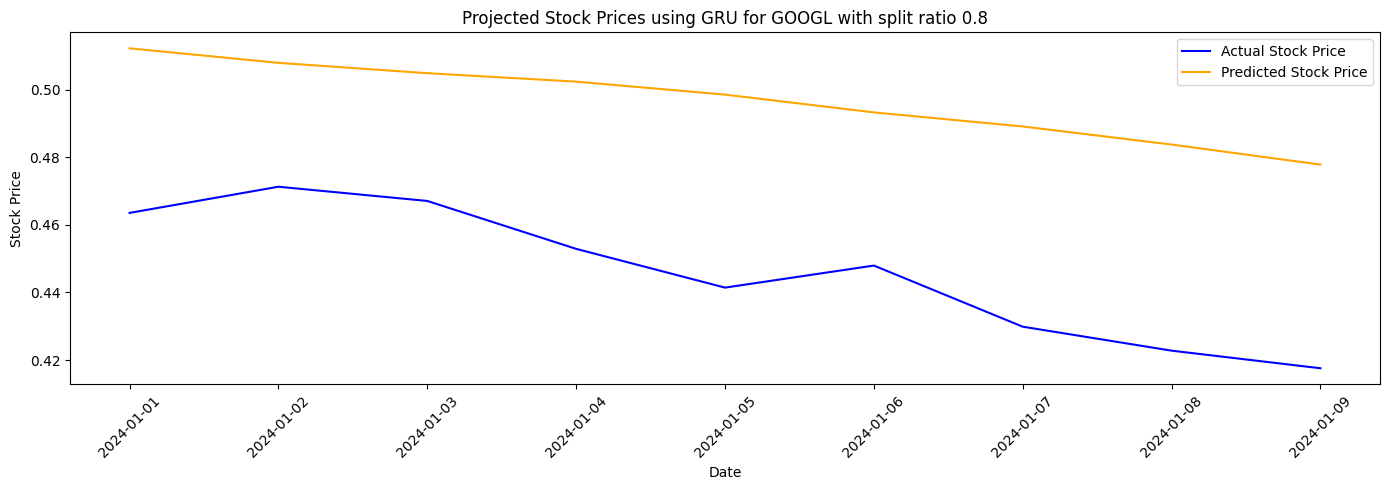

Epoch 1/2
3/3 [==============================] - 4s 311ms/step - loss: 0.3441 - val_loss: 0.0159
Epoch 2/2
1/1 [==============================] - 1s 528ms/step
Plotting: Projected Stock Prices using GRU for GOOGL with split ratio 0.8
Dates: DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09'],
              dtype='datetime64[ns]', freq='D')
y_test: [0.46357678 0.47132386 0.46711145 0.45292599 0.4414459  0.44797906
 0.42987126 0.42277203 0.41755945]
test_predict: [0.52722043 0.52199084 0.51850532 0.51558396 0.51072474 0.50417559
 0.49911038 0.49235884 0.48493942]


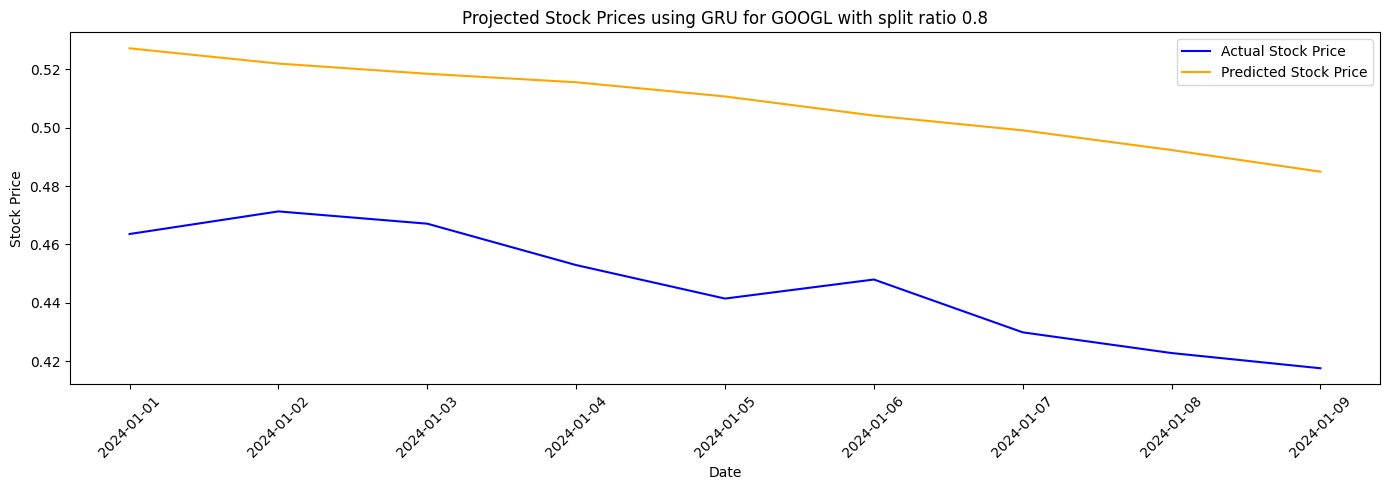

Data length for MSFT after scaling: 100
Epoch 1/2
69/69 [==============================] - 5s 18ms/step - loss: 0.0187 - val_loss: 0.0049
Epoch 2/2
1/1 [==============================] - 1s 595ms/step
Plotting: Projected Stock Prices using LSTM for MSFT with split ratio 0.8
Dates: DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09'],
              dtype='datetime64[ns]', freq='D')
y_test: [0.49348156 0.50242897 0.50945796 0.52236855 0.51287411 0.51593192
 0.51717357 0.51290375 0.5251866 ]
test_predict: [0.53925896 0.53606959 0.53596075 0.53762756 0.54159555 0.54549281
 0.54972281 0.55312809 0.55732545]


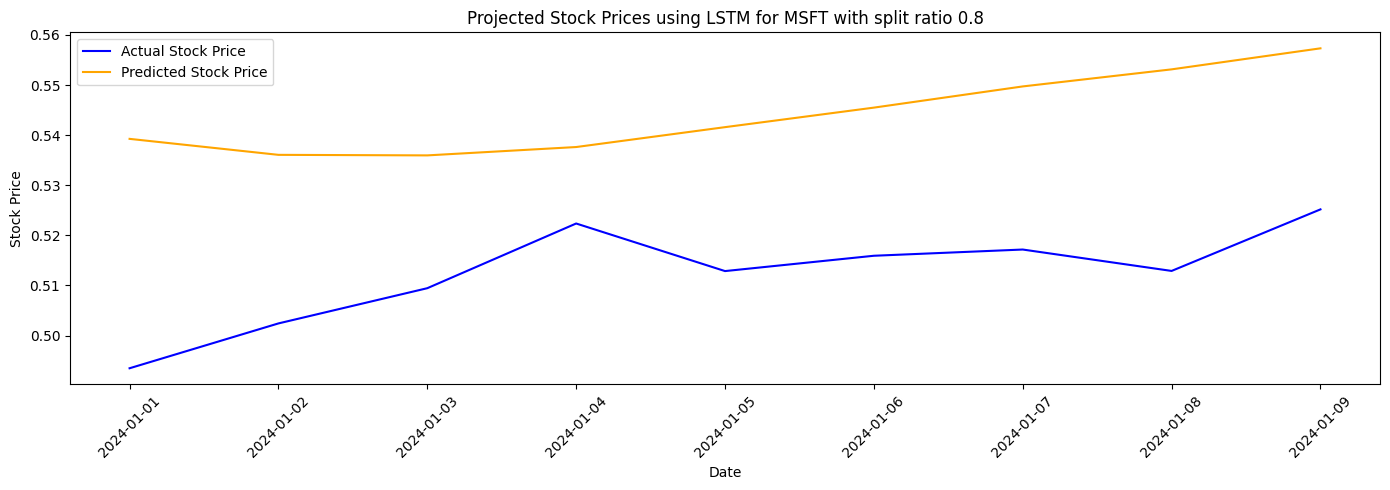

Epoch 1/2
3/3 [==============================] - 5s 748ms/step - loss: 0.0732 - val_loss: 0.5010
Epoch 2/2
1/1 [==============================] - 1s 631ms/step
Plotting: Projected Stock Prices using LSTM for MSFT with split ratio 0.8
Dates: DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09'],
              dtype='datetime64[ns]', freq='D')
y_test: [0.49348156 0.50242897 0.50945796 0.52236855 0.51287411 0.51593192
 0.51717357 0.51290375 0.5251866 ]
test_predict: [0.4542041  0.45367403 0.45362253 0.45382301 0.45433783 0.45486404
 0.45545467 0.45590587 0.45654013]


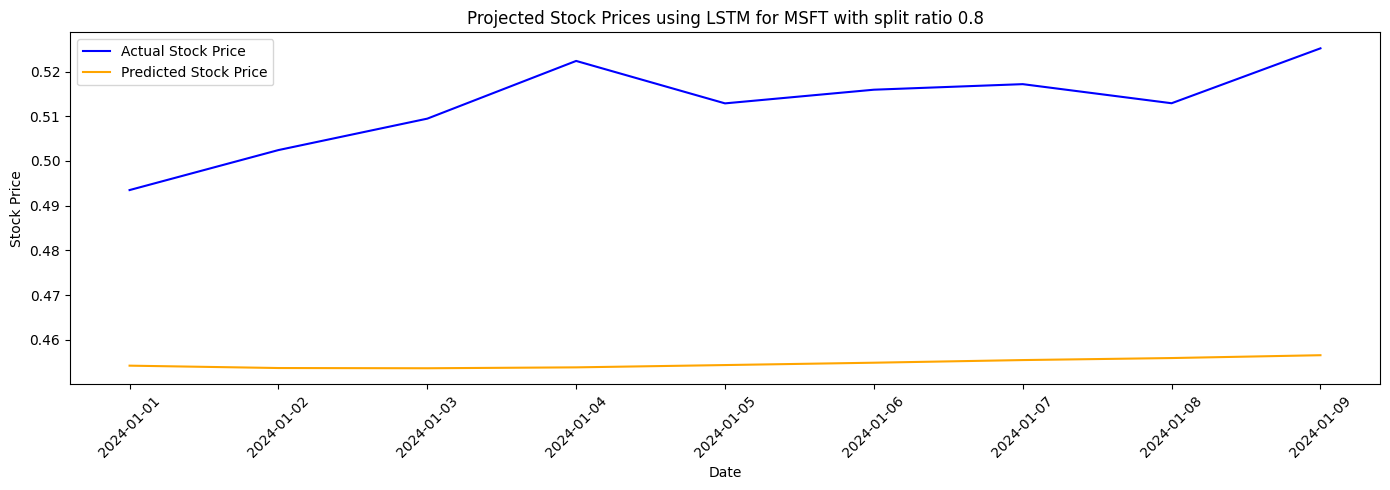

Epoch 1/2
69/69 [==============================] - 5s 19ms/step - loss: 0.0084 - val_loss: 0.0650
Epoch 2/2
1/1 [==============================] - 1s 522ms/step
Plotting: Projected Stock Prices using GRU for MSFT with split ratio 0.8
Dates: DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09'],
              dtype='datetime64[ns]', freq='D')
y_test: [0.49348156 0.50242897 0.50945796 0.52236855 0.51287411 0.51593192
 0.51717357 0.51290375 0.5251866 ]
test_predict: [0.50338    0.50266928 0.50481866 0.50909817 0.51639694 0.52011534
 0.52280554 0.52487426 0.52515693]


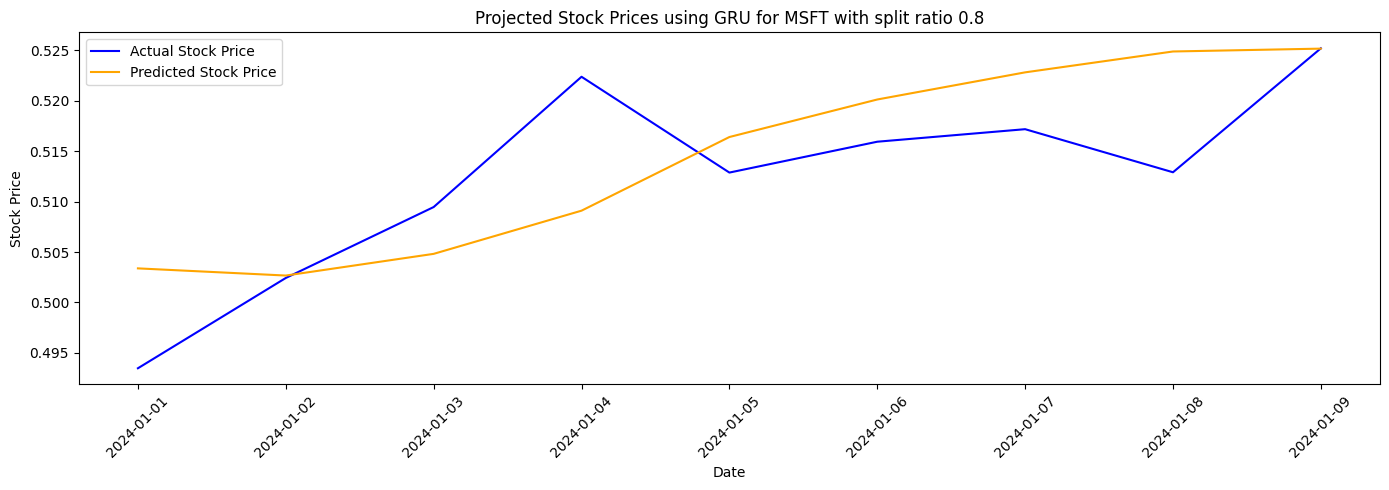

Epoch 1/2
3/3 [==============================] - 4s 315ms/step - loss: 0.0686 - val_loss: 0.2887
Epoch 2/2
1/1 [==============================] - 1s 547ms/step
Plotting: Projected Stock Prices using GRU for MSFT with split ratio 0.8
Dates: DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09'],
              dtype='datetime64[ns]', freq='D')
y_test: [0.49348156 0.50242897 0.50945796 0.52236855 0.51287411 0.51593192
 0.51717357 0.51290375 0.5251866 ]
test_predict: [0.48080515 0.48025414 0.48066998 0.48196632 0.48444376 0.48638111
 0.48798414 0.48925295 0.48999765]


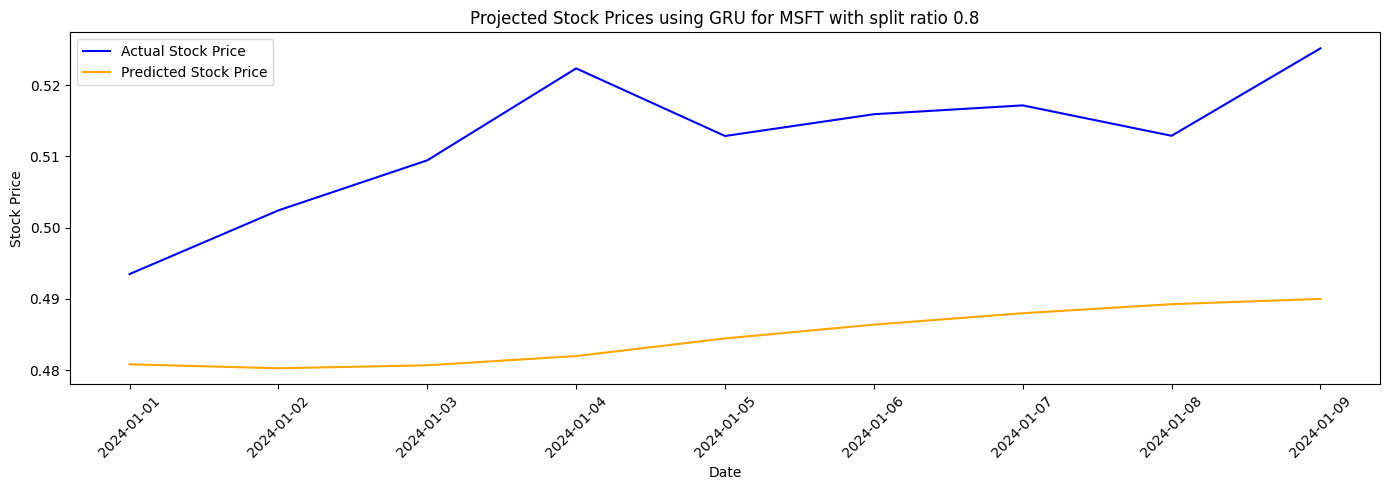

In [28]:
# Model Training and Evaluation for Each Stock
time_step = 10  # Further reduced time step to ensure there is enough data
split_ratios = [0.8]  # List of split ratios
hyperparams = [{'epochs': 2, 'batch_size': 1}, {'epochs': 2, 'batch_size': 32}]
stocks = ['AAPL', 'GOOGL', 'MSFT']

for stock in stocks:
    stock_data = data[stock]  # Get specific stock data as a Series
    stock_data, data_scaled, scaler = process_stock_data(stock_data)
    print(f"Data length for {stock} after scaling: {len(data_scaled)}")
    if len(data_scaled) <= time_step:
        print(f"Not enough data for stock {stock} with time_step {time_step}")
        continue

    for split_ratio in split_ratios:
        train_data, test_data = split_data(data_scaled, split_ratio)
        X_train, y_train = create_dataset(train_data, time_step)
        X_test, y_test = create_dataset(test_data, time_step)

        # Check if there is enough data to reshape
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"Not enough data for stock {stock} with time_step {time_step}")
            continue

        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        # Train and evaluate LSTM models
        for params in hyperparams:
            model_lstm, history_lstm = build_and_train_lstm(X_train, y_train, X_test, y_test, epochs=params['epochs'], batch_size=params['batch_size'], time_step=time_step)
            rmse_lstm, mae_lstm, r2_lstm, y_test_lstm, test_predict_lstm = evaluate_model(model_lstm, X_test, y_test, scaler)
            start_date = pd.to_datetime('2024-01-01')
            dates = pd.date_range(start=start_date, periods=len(y_test_lstm), freq='D')
            plot_projected_prices(dates, y_test_lstm, test_predict_lstm, f'Projected Stock Prices using LSTM for {stock} with split ratio {split_ratio}')

        # Train and evaluate GRU models
        for params in hyperparams:
            model_gru, history_gru = build_and_train_gru(X_train, y_train, X_test, y_test, epochs=params['epochs'], batch_size=params['batch_size'], time_step=time_step)
            rmse_gru, mae_gru, r2_gru, y_test_gru, test_predict_gru = evaluate_model(model_gru, X_test, y_test, scaler)
            start_date = pd.to_datetime('2024-01-01')
            dates = pd.date_range(start=start_date, periods=len(y_test_gru), freq='D')
            plot_projected_prices(dates, y_test_gru, test_predict_gru, f'Projected Stock Prices using GRU for {stock} with split ratio {split_ratio}')








In [34]:
! pip install yfinance
! pip install prophet
! pip install gradio

In [35]:
import gradio as gr
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
from prophet import Prophet
import numpy as np

def get_nearest_date(date, date_series):
    return date_series[np.abs(date_series - date).argmin()]

def get_stock_info(symbol):
    try:
        stock = yf.Ticker(symbol)

        # Get historical data for the past 10 years (if available)
        end_date = datetime.now()
        start_date = end_date - timedelta(days=3650)  # Approximately 10 years
        hist = stock.history(start=start_date, end=end_date)

        if hist.empty:
            raise ValueError(f"No data available for symbol {symbol}")

        # Get the current price (last available closing price)
        current_price = hist['Close'].iloc[-1]

        # Get the most recent opening and closing prices
        latest_data = hist.iloc[-1]
        opening_price = latest_data['Open']
        closing_price = latest_data['Close']

        # Calculate max and min prices
        max_price = hist['High'].max()
        min_price = hist['Low'].min()

        # Prepare data for Prophet
        prophet_data = hist.reset_index()[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
        # Remove timezone information
        prophet_data['ds'] = prophet_data['ds'].dt.tz_localize(None)

        # Create and fit the Prophet model
        model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
        model.fit(prophet_data)

        # Generate future dates for prediction (10 years)
        future_dates = model.make_future_dataframe(periods=3650)

        # Make predictions
        forecast = model.predict(future_dates)

        # Get predictions for 1, 5, and 10 years
        pred_dates = [end_date + timedelta(days=365), end_date + timedelta(days=1825), end_date + timedelta(days=3650)]
        pred_labels = ["1 year", "5 years", "10 years"]
        predictions = []

        for date in pred_dates:
            nearest_date = get_nearest_date(date, forecast['ds'])
            pred_price = forecast[forecast['ds'] == nearest_date]['yhat'].values[0]
            predictions.append(pred_price)

        # Create plots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

        # Historical price plot
        ax1.plot(hist.index, hist['Close'])
        ax1.set_title(f"{symbol} Stock Price - Historical Data")
        ax1.set_xlabel("Date")
        ax1.set_ylabel("Price (USD)")
        ax1.grid(True)

        # Forecast plot
        model.plot(forecast, ax=ax2)
        ax2.set_title(f"{symbol} Stock Price - 10 Year Forecast")
        ax2.set_xlabel("Date")
        ax2.set_ylabel("Price (USD)")

        plt.tight_layout()

        return (
            f"Current price of {symbol}: ${current_price:.2f}",
            f"Opening price: ${opening_price:.2f}",
            f"Closing price: ${closing_price:.2f}",
            f"Max price: ${max_price:.2f}",
            f"Min price: ${min_price:.2f}",
            f"Predicted price (1 year): ${predictions[0]:.2f}",
            f"Predicted price (5 years): ${predictions[1]:.2f}",
            f"Predicted price (10 years): ${predictions[2]:.2f}",
            fig
        )
    except Exception as e:
        return str(e), "", "", "", "", "", "", "", None

# Create the Gradio interface
app = gr.Interface(
    fn=get_stock_info,
    inputs=gr.Textbox(label="Enter stock symbol (e.g., AAPL, GOOGL)"),
    outputs=[
        gr.Textbox(label="Current Price"),
        gr.Textbox(label="Opening Price"),
        gr.Textbox(label="Closing Price"),
        gr.Textbox(label="Max Price"),
        gr.Textbox(label="Min Price"),
        gr.Textbox(label="Predicted Price (1 year)"),
        gr.Textbox(label="Predicted Price (5 years)"),
        gr.Textbox(label="Predicted Price (10 years)"),
        gr.Plot(label="Price Chart and Forecast")
    ],
    title="Stock Price Viewer and Long-Term Predictor",
    description="Enter a stock symbol to view its current, opening, closing, max, and min prices, along with a price chart and 1, 5, and 10-year forecasts."
)

# Launch the app
app.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://9093b6ca0e79ded3d4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
